# Импорт библиотек

In [1]:
import pandas as pd
import glob
import numpy as np
from sklearn.neighbors import BallTree, KDTree, DistanceMetric
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import subprocess
from tqdm import tqdm

# Обзор данных

## Прочитаем тестовые данные

In [2]:
test = pd.concat([pd.read_hdf(file) for file in ['data/test_close0.h5', 'data/test_close10.h5']])
test.head()

,TX,TY,X,Y,Z,data_ind
0,0.087240,0.119438,86536.218750,62988.312500,56892.0,0
1,-0.380208,0.198382,93346.765625,58062.937500,14223.0,0
2,-0.348549,-0.099981,66129.578125,23038.673828,46548.0,0
3,0.585342,-0.126879,68825.523438,55186.625000,45255.0,0
4,0.038579,-0.131510,36366.941406,47564.878906,9051.0,0


# Попробуем теперь визуализировать данные

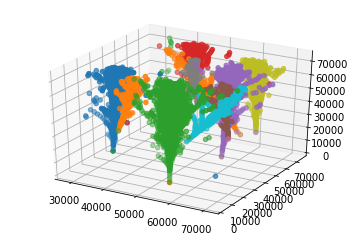

In [6]:
df_open30 = pd.read_hdf('data/dm4/open30.h5')
first = df_open30[df_open30.data_ind == df_open30.data_ind[0]]

for index in first.event_id.unique()[1:]:
    ev = first[first.event_id == index]
    ax = plt.gca(projection='3d')
    ax.scatter3D(ev.X, ev.Y, ev.Z)

## Видно, что в одной группе несколько ливней. Давайте попробуем взглянуть как распределены шум и сигнал вдоль осей.

In [9]:
def make_plot(axis):
    figure = plt.figure(figsize = [20, 10])
    figure.suptitle('Распредление шума и сигнала вдоль ' + axis, fontsize=20)
    
    figure.add_subplot(221)
    plt.title('Сигнал')
    plt.hist(first.loc[first.signal == 1, axis], bins=1000, histtype='step', color = 'green')
    
    figure.add_subplot(222)
    plt.title('Шум')
    plt.hist(first.loc[first.signal == 0, axis], bins=1000, histtype='step', color = 'red')
    
    figure.add_subplot(223)
    plt.title('Все значения')
    values_X = plt.hist(first.loc[:, axis], bins=1000, histtype='step', color = 'blue')
    
    plt.show()

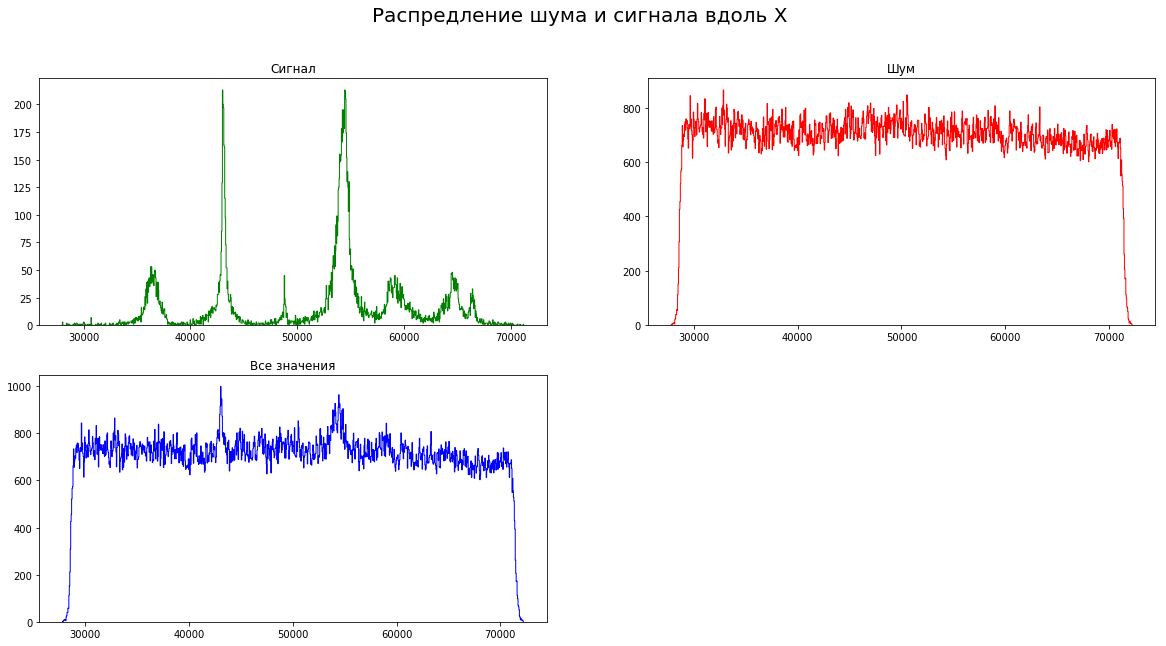

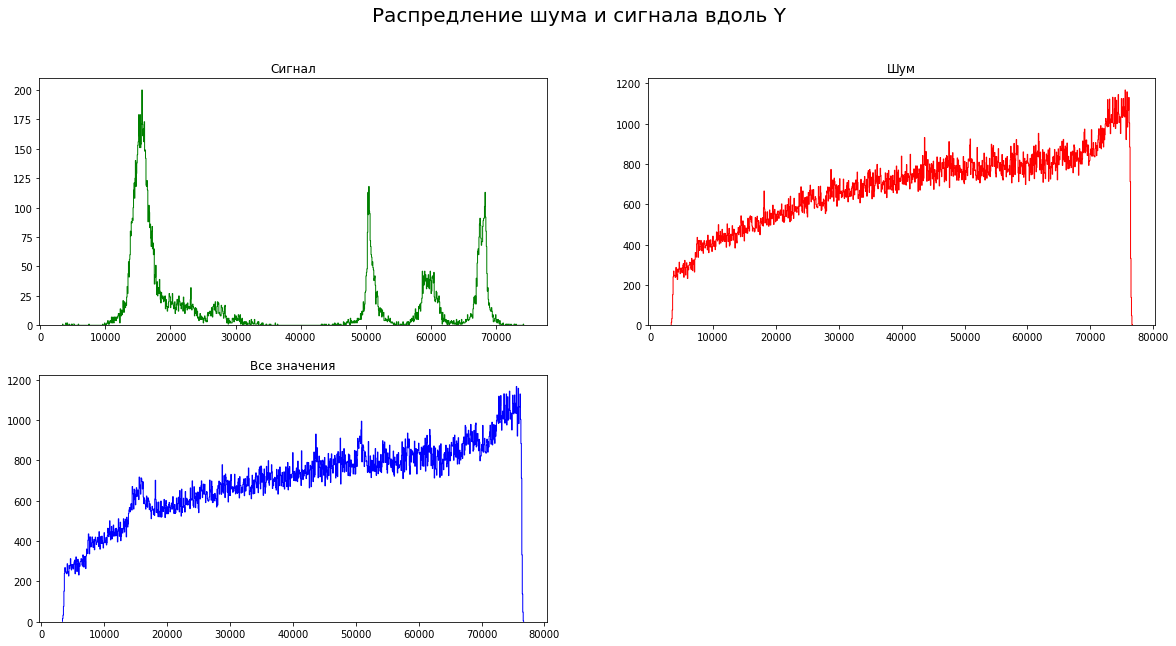

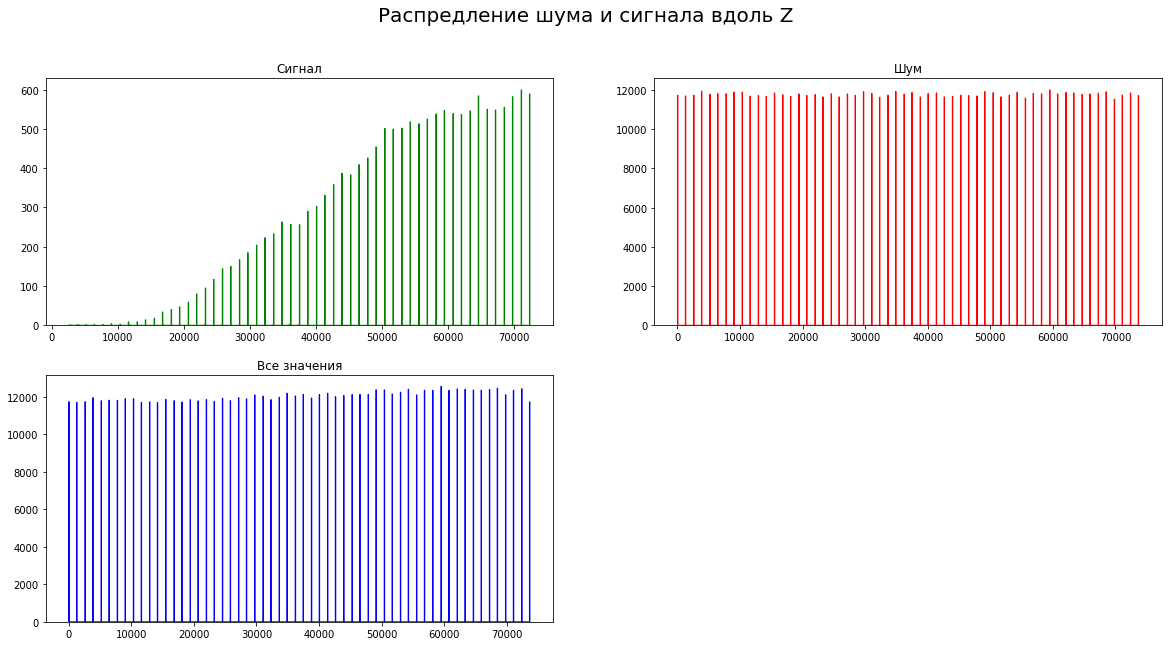

In [10]:
for axis in ['X', 'Y', 'Z']:
    make_plot(axis)

## Можно заметить, что слайсы по Z практически на одинаковом расстоянии. Посмотрим, что это за расстояние.

In [11]:
z_values = np.array(sorted(np.unique(first.Z)))
between_z = []

for i in range(1, len(z_values)):
    between_z.append(int(z_values[i] - z_values[i - 1]))
    
unique, counts = np.unique(between_z, return_counts = True)
print(np.asarray((unique, counts)).T)

[[   0    1]
 [   1    1]
 [   2    1]
 [  22    1]
 [  51    1]
 [  62    1]
 [  75    1]
 [ 157    1]
 [ 182    1]
 [ 221    1]
 [ 244    1]
 [ 272    1]
 [ 294    1]
 [ 998    1]
 [1020    1]
 [1048    1]
 [1069    1]
 [1110    1]
 [1135    1]
 [1217    1]
 [1230    1]
 [1241    1]
 [1268    1]
 [1293   47]]


## Получается, что это расстояние 1293

# Группировка на пары

## Ребята рассказали, что необходимо разбить данные на пары с помощью BallTree в пространстве координат и углов.

In [12]:
columns = ['TX', 'TY', 'X', 'Y', 'Z']
for_metric = columns[:-1]

def add_neighbours(df, k, same_pair, metric='minkowski'):
    result = []
    
    for data_ind in tqdm(df.data_ind.unique()):
        ind = df[df.data_ind == data_ind]
        values = list(sorted(ind.Z.unique()))
        for z, z_next in zip(values, values[1:]):
            z, z_next = ind[ind.Z == z].copy(), ind[ind.Z == z_next].copy()
#             1293 расстояние между слайсами, которое получили ранее
            z[['TX', 'TY']] *= 1293
            z_next[['TX', 'TY']] *= 1293
            
            b_tree = BallTree(z_next[for_metric], metric=metric)
            d, idx = b_tree.query(z[for_metric], k=min(k, len(z_next)))
            
            for i in range(idx.shape[1]):
                data = z_next.iloc[idx[:, i]]
                temp = z.copy()
                for col in columns:
                    temp[col + '_pair'] = data[col].values
                if same_pair:
                    temp['same_pair'] = data.event_id.values == z.event_id.values
                result.append(temp)
            
        result.append(z_next)
        
    result = pd.concat(result)
    for col in columns:
        result['d' + col] = result[col].values - result[col + '_pair'].values
    return result

def make_train(df, k):
    t = add_neighbours(df, k=k, same_pair=True)
    noise = t.event_id == -999
    signal, not_signal = t[~noise], t[noise]
    noise_part = not_signal.sample(len(signal))
    return pd.concat([signal, noise_part]).reset_index(drop=True)

# Обучение

In [14]:
train = []
for file in glob.glob('data/open*.h5')[:5]:
    train.append(make_train(pd.read_hdf(file), k=3))
    
train = pd.concat(train)


100%|██████████| 1/1 [00:04<00:00,  4.02s/it]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False


100%|██████████| 10/10 [00:40<00:00,  4.09s/it]

100%|██████████| 10/10 [00:37<00:00,  3.79s/it]

100%|██████████| 10/10 [00:37<00:00,  3.76s/it]

100%|██████████| 10/10 [00:44<00:00,  4.41s/it]


## Выделяем нужные данные для обучения

In [15]:
y_train = train.signal
X_train = train.drop(['event_id', 'signal', 'data_ind', 'same_pair'], axis=1)

## Создаем и обучаем модель

In [16]:
lgb_train = lgb.Dataset(X_train, y_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'max_depth': 15,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 4
}

lgb.cv(params, lgb_train, 20, nfold=5)

{'auc-mean': [0.8320600209544569,
  0.8488470698498569,
  0.8526797095629737,
  0.864726726310647,
  0.8667577794083903,
  0.8656804070899945,
  0.8710927559057506,
  0.8721733718999284,
  0.8751765823999401,
  0.8767087870198929,
  0.8776444043769016,
  0.8781334277005926,
  0.8795794672210139,
  0.8802046652644986,
  0.881130917202951,
  0.883124974182364,
  0.884629206612219,
  0.8858460792841019,
  0.8866968928865389,
  0.8879294096837274],
 'auc-stdv': [0.00029190822817422703,
  0.0005242115829443528,
  0.0007336692724574793,
  0.0009052709610978906,
  0.0010048182986044012,
  0.001068743729623215,
  0.000765632102289496,
  0.0006634684050315362,
  0.0006768547770660295,
  0.0006410759093955525,
  0.0008755784934038386,
  0.0007166443303063088,
  0.0005844054162504729,
  0.0008267390067561566,
  0.00044222081384203955,
  0.0005466139030458402,
  0.0006658515631724037,
  0.0006019532437094677,
  0.000461401564793524,
  0.00041768870031688504]}

In [17]:
bst = lgb.train(params, lgb_train, 100)

# Добавляем соседей к тестовому датасету  

In [18]:
test_with_neighbours = add_neighbours(test, k=3, same_pair=False)


100%|██████████| 11/11 [00:43<00:00,  3.93s/it]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [19]:
X_test = test_with_neighbours.drop(['data_ind'], axis=1).reset_index(drop=True)
X_test.head()

,TX,TX_pair,TY,TY_pair,X,X_pair,Y,Y_pair,Z,Z_pair,dTX,dTY,dX,dY,dZ
0,-193.084152,-350.331818,623.975891,437.505890,37949.000000,38081.851562,24967.570312,24522.312500,0.0,1293.0,157.247665,186.470001,-132.851562,445.257812,-1293.0
1,-225.433212,-380.564331,-367.239899,458.562836,39335.953125,39409.578125,49094.968750,49534.917969,0.0,1293.0,155.131119,-825.802734,-73.625000,-439.949219,-1293.0
2,-288.543915,-166.982605,744.821838,638.900269,51992.125000,51851.539062,74045.695312,73873.390625,0.0,1293.0,-121.561310,105.921570,140.585938,172.304688,-1293.0
3,-131.043716,-486.173767,-389.968414,107.317078,29508.035156,29299.156250,67410.984375,67238.296875,0.0,1293.0,355.130066,-497.285492,208.878906,172.687500,-1293.0
4,-233.201782,135.409042,573.095337,775.318970,67685.781250,67272.015625,75164.359375,75664.359375,0.0,1293.0,-368.610840,-202.223633,413.765625,-500.000000,-1293.0


## В качестве финального предсказания возьмём среднюю вероятность для каждой точки

(6998081, 3)

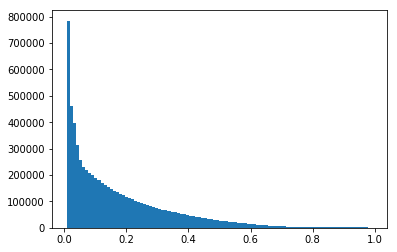

In [20]:
pred = bst.predict(X_test)
raw = pd.DataFrame({'id': test_with_neighbours.index, 'prob': pred}).groupby('id')
agg = raw.aggregate(('mean', 'max', 'min'))['prob']
plt.hist(agg['mean'], bins=100);
agg.shape

In [ ]:
result = pd.DataFrame(data={'id': agg.index, 'signal': agg['mean'].values.astype('float16')}) 

result.to_csv('submit.csv', index=False)